# Collaborative Filtering based Recommender Systems

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error

%matplotlib inline
# sets the backend of matplotlib to the 'inline' backend:
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

sns.set(style='whitegrid', palette='muted', font_scale=1.3)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

UsageError: Line magic function `%matpl=otlib` not found.


## Load the data
You can download the file `hetrec2011-lastfm-2k.zip`[here](https://grouplens.org/datasets/hetrec-2011/) and then unzip into the `data/` directory.

In [ ]:
plays = pd.read_csv('data/user_artists.dat', sep='\t')
print("plays weight means listening count for each [user, artist] pair): \n", plays.head())
artists = pd.read_csv('data/artists.dat', sep='\t', usecols=['id','name'])
print("artists: \n", artists.head())
ap = pd.merge(artists, plays, left_on="id", right_on="artistID")
ap = ap.rename(columns={"weight": "playCount"})
ap.head()

In [ ]:
artist_rank = ap.groupby(['name']).agg({'userID' : 'count', 'playCount' : 'sum'}) \
  .rename(columns={"userID" : 'totalUniqueUsers', "playCount" : "totalArtistPlays"}) \
  .sort_values(['totalArtistPlays'], ascending=False)

print("artist_rank: \n", artist_rank.head())

artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays'] / artist_rank['totalUniqueUsers']

print("artist_rank with avgUserPlays: \n", artist_rank.head())

ap = ap.join(artist_rank, on="name", how="inner").sort_values(['playCount'], ascending=False)
ap.head()

# Exploration

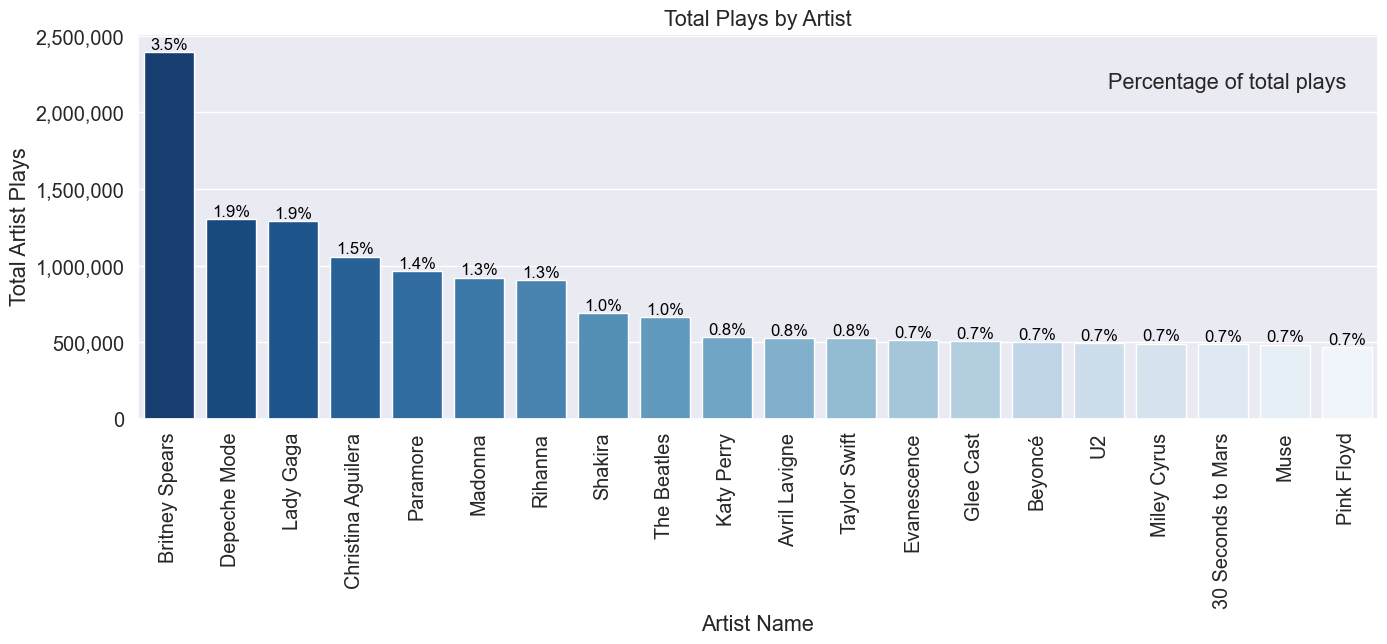

In [27]:
def bar_chart_int(dataframeName, y, x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(dataframeName, x="name", y=y, hue="name", palette='Blues_r')
    #Blues_r means Blues reverse
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black', fontsize=12) 

    # our caption statement
    ax.text(19, max(dataframeName[y])*0.9, caption,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()

bar_chart_int(dataframeName=artist_rank[:20], y="totalArtistPlays", x_label='Artist Name',y_label='Total Artist Plays',title='Total Plays by Artist',caption='Percentage of total plays', total_val=artist_rank.totalArtistPlays.sum())

number of distinct userID 1892


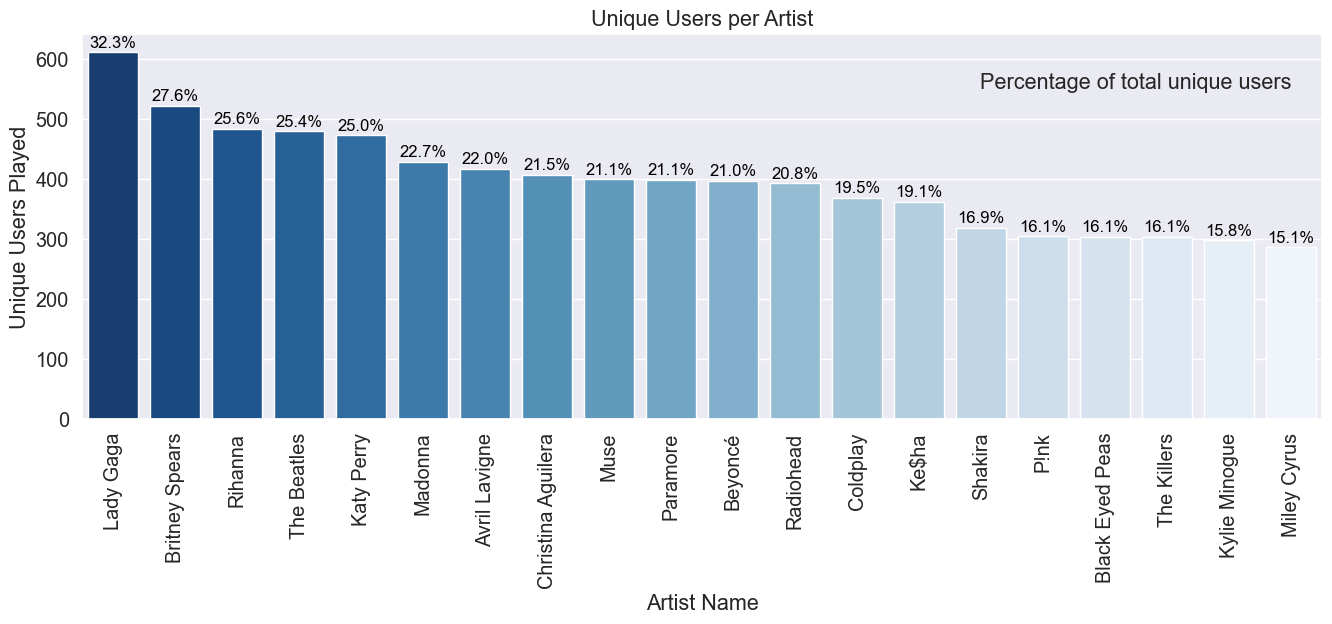

In [28]:
dataframeName = artist_rank.sort_values(['totalUniqueUsers'],ascending=False)
total_val = ap.userID.nunique()
print("number of distinct userID", total_val)
# Count number of distinct userID

bar_chart_int(dataframeName=dataframeName[:20],y="totalUniqueUsers",x_label='Artist Name',y_label='Unique Users Played',title='Unique Users per Artist',caption='Percentage of total unique users',total_val=total_val)

# Preprocessing

In [29]:
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
ap = ap.assign(playCountScaled=play_count_scaled)
print("ap with playCountScaled \n", ap.head())
ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
# Return reshaped DataFrame organized by given index / column values.
print("ratings_df \n", ratings_df.head())

ratings = ratings_df.fillna(0).values

sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

ap with playCountScaled 
         id          name  userID  artistID  playCount  totalUniqueUsers  \
2800    72  Depeche Mode    1642        72     352698               282   
35843  792        Thalía    2071       792     324663                26   
27302  511            U2    1094       511     320725               185   
8152   203          Blur    1905       203     257978               114   
26670  498      Paramore    1664       498     227829               399   

       totalArtistPlays  avgUserPlays  playCountScaled  
2800            1301308   4614.567376         1.000000  
35843            350035  13462.884615         0.920513  
27302            493024   2664.994595         0.909347  
8152             318221   2791.412281         0.731441  
26670            963449   2414.659148         0.645960  
ratings_df 
 artistID  1      2      3      4      5      6      7      8      9      \
userID                                                                    
2           NaN   

In [30]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            # if this user has rated more than MIN_USER_RATINGS=35 artists
            # delete DELETE_RATING_COUNT=15 of the ratings
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [31]:
train, val = train_test_split(ratings)
print("ratings shape", ratings.shape, " number of nonzero:", np.count_nonzero(ratings))
print("training shape", train.shape, " number of nonzero:", np.count_nonzero(train))
print("validation shape", val.shape, " number of nonzero:", np.count_nonzero(val))

ratings shape (1892, 17632)  number of nonzero: 92198
training shape (1892, 17632)  number of nonzero: 64748
validation shape (1892, 17632)  number of nonzero: 27450


In [32]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

# Training by SGD

In [33]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [34]:
recommender = Recommender().fit(train, val)

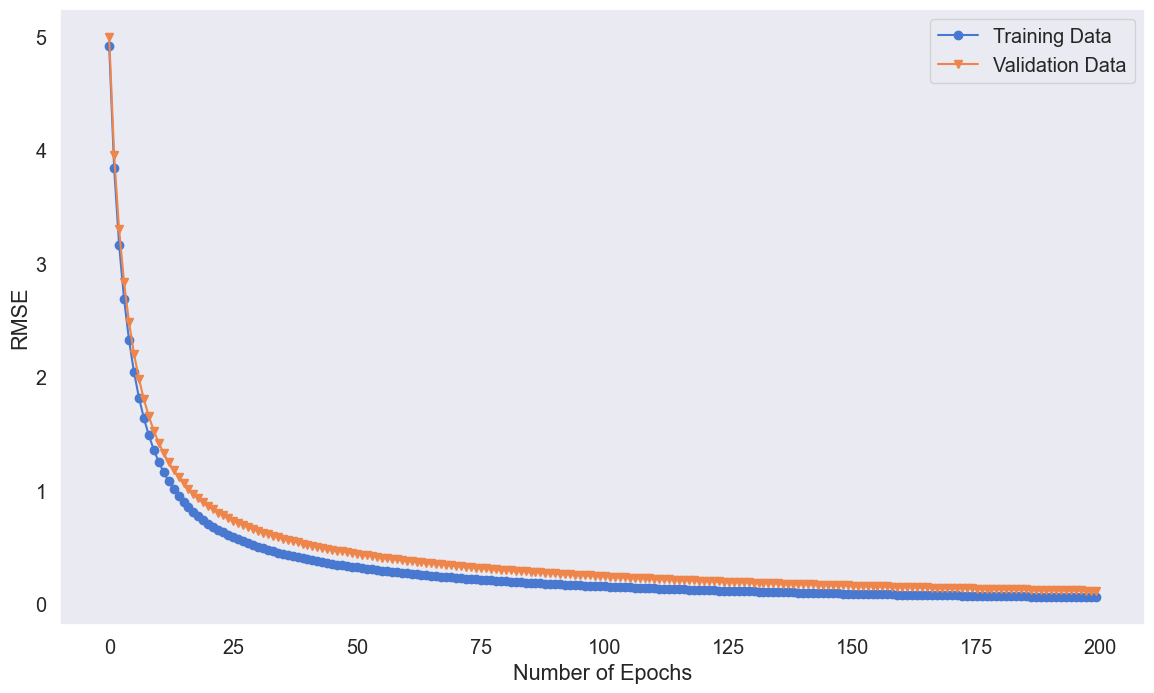

In [35]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data')
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

# Making recommendations

In [36]:
user_id = 1236
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]
rating_predictions = recommender.predict(train, user_index)

In [37]:
def create_artist_ratings(artists_df, artists_index, ratings, n=10):
  artist_ids = ratings_df.columns[artists_index]
  artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
  top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
  
  artist_recommendations = artists_df[artists_df.id.isin(top_n_artists.artistId)].reset_index(drop=True)
  artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
  return artist_recommendations.sort_values("rating", ascending=False)

In [38]:
create_artist_ratings(artists, predictions_index, rating_predictions)

,id,name,rating
0,1318,Sander van Doorn,0.559202
1,3167,Jacob Miller,0.552893
2,7627,Celtas Cortos,0.552142
3,10995,Camisa de Vênus,0.546361
4,12186,Ella Fitzgerald & Louis Armstrong,0.541477
5,12911,The Answer,0.537367
6,14245,Anjelika Akbar,0.536756
7,14940,Medications,0.536486
8,15792,Lützenkirchen,0.535515
9,18559,Archie Star,0.535147
